## Attention

* Кодирование производится с помощью BiLSTM (не принципиально)
* Веса $a_i$ обычно в сумме равны $1$

<img src="images/attention.png" alt="Drawing" style="width: 500px;"/>

Визуализируя веса, можно понимать стратегию получения результата (от каких частей контекста зависела каждая из частей выхода).


Пример визуализации весов $attention$ в задаче машинного перевода

<img src="images/attention_matrix.png" alt="Drawing" style="width: 480px;"/>

При использовании BiLSTM каждый вектор $h_j$ хранит информацию о всей последовательности, но в наибольшей степени о $j$-м слове и его соседях.


Далее при текущем выходе $y_{t−1}$ (с вектором $s_{t−1}$) для вектора каждого входного слова $h_j$ считается $a_{tj}$ – вклад в генерацию следующего выходного вектора ($attention$):

$$a_{tj} = \frac {e^{e_{tj}}} {\sum_k e^{e_{tk}}}$$

где $e_{tj} = f (s_{t−1}, h_j )$ – модель выравнивания


􏰀Модель выравнивания предсказывает то, насколько хорошо соотносятся входное слово в позиции j и выходное в позиции t (обычно это простая модель, например, однослойная сеть)

#### Multi-head attention

Вход: вектор запроса и несколько пар векторов ключей и значений (ключ и значение обычно совпадают)

<img src="images/multi-head-attention.png" alt="Drawing" style="width: 400px;"/>

Для запроса и каждого ключа считается вес (линейный слой)
Значения суммируются с этими весами в итоговый вектор

Идея: обучать несколько $attention$, в надежде, что они станут отвечать за разные признаки слов

Результаты пропустим через однослойную сеть, получим на выходе один вектор той же размерности, что и входные вектора.

## Transformer

Состоит из encoder и decoder, в каждом используются $multi$-$head\ attention$ и полносвязные (свёрточные) слои (нет RNN)

Для каждого слова в encoder формируется вектор на основе нескольких слоёв $multi$-$head\ attention$, который передаётся в декодер.


􏰀На основании векторов энкодера, а также выходных векторов для уже обработанных слов получается вектор для текущего слова. В обоих случаях используется $multi$-$head\ attention$.

<img src="images/transformer.png" alt="Drawing" style="width: 500px;"/>

$Positional\ encoding$ – дополнительный вектор признаков для каждого слова, представляющий собой набор значений синусов и косинусов с разными периодами от позиции слова в предложении

В трансформере и в encoder, и в decoder можно использовать несколько последовательных слоёв $multi$-$head\ attention$.

Для большей выразительности и качества добавляют полносвязные слои, а также дропаут, нормализацию по слою и residual connections.

Важная особенность: обучение модели внутри предложения можно распараллелить, в отличие от RNN.

## BERT

$BERT\ (Bidirectional\ Encoder\ Representations\ from\ Transformers)\ -$ многослойный двунаправленный transformer-encoder.

#### Model architecture 

Модель BERT основана на архитектуре Transformer и является усовершенствованием модели GPT от OpenAI.
Модель, в отличие от GPT является двунаправленной.

Ссылка на оригинальную статью: https://arxiv.org/abs/1810.04805

<img src="images/bert_model.png" alt="Drawing" style="width: 550px;"/>

Основные параметры модели:
* L – количество $transformer$-блоков 
* H – размер скрытого представления,
* A – количество параллельных слоев в $multi$-$head$ $attention$

Существует две основные модели от Google:

* $BERT_{BASE}$: 
    * L = 12
    * H = 768
    * A = 12, 
    * Total = 110M
$$$$
* $BERT_{LARGE}$: 
    * L = 24
    * H = 1024
    * A = 16, 
    * Total = 340M


Модель обучается на двух задачах: 
* Masked Language Modeling.
* Next sentence prediction.

#### Masked Language Modeling

В отличие от обычного Language Modeling, где предсказывается каждое следующее слово на каждом шаге, в задаче Masked Language Modeling случайные токены заменяются на специальный токен [MASK] и предсказываются только эти "замаскированные" токены.

* 80% времени обучения: Заменим слово на [MASK].
    * my dog is hairy → my dog is [MASK]
* 10% времени обучения: Заменим слово на другое случайное слово 
    * my dog is hairy → my dog is apple
* 10% времени обучения: оставим предложение без изменений. Цель этого - сделать модель смещенной в сторону слова, которое действительно встречалось в корпусе в данном предложении. 
    * my dog is hairy → my dog is hairy. 

#### Next sentence prediction 

Next sentence prediction $-$ задача бинарной классификации. По паре предложений требуется определить, является ли второе предложение продолжением первого.

* Input =[CLS] the man went to [MASK] store [SEP] he bought a gallon [MASK] milk [SEP]
    * Label = IsNext
$$$$
* Input =[CLS] the man [MASK] to the store [SEP] penguin [MASK] are flight ##less birds [SEP]
    * Label = NotNext

#### BERT Embeddings

Посмотрим на эмбеддинги, получаемые с помощью модели BERT. 

Будем использовать модель $BERT_{base}$ из реализации transformers от HuggingFace. 
Ссылка на их гитхаб: https://github.com/huggingface/transformers

Примеры текстов взяты из туториала (https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
# % matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
text = "Here is the sentence I want embeddings for."
text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."
marked_text = "[CLS] " + text + " [SEP]"

print (marked_text)

[CLS] After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank. [SEP]


In [5]:
tokenized_text = tokenizer.tokenize(marked_text)
print (tokenized_text)

['[CLS]', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.', '[SEP]']


In [6]:
print(list(tokenizer.vocab.keys())[5000:5020])

['knight', 'lap', 'survey', 'ma', '##ow', 'noise', 'billy', '##ium', 'shooting', 'guide', 'bedroom', 'priest', 'resistance', 'motor', 'homes', 'sounded', 'giant', '##mer', '150', 'scenes']


In [7]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
    print (tup)

('[CLS]', 101)
('after', 2044)
('stealing', 11065)
('money', 2769)
('from', 2013)
('the', 1996)
('bank', 2924)
('vault', 11632)
(',', 1010)
('the', 1996)
('bank', 2924)
('robber', 27307)
('was', 2001)
('seen', 2464)
('fishing', 5645)
('on', 2006)
('the', 1996)
('mississippi', 5900)
('river', 2314)
('bank', 2924)
('.', 1012)
('[SEP]', 102)


In [8]:
segments_ids = [1] * len(tokenized_text)
print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [15]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# Put the model in "evaluation" mode, meaning feed-forward operation.
model = model.eval()

In [16]:
# Predict hidden states features for each layer
with torch.no_grad():
    out = model(tokens_tensor, segments_tensors)

In [18]:
encoded_layers = out[2]

In [20]:
encoded_layers[0].shape

torch.Size([1, 22, 768])

In [21]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 13
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


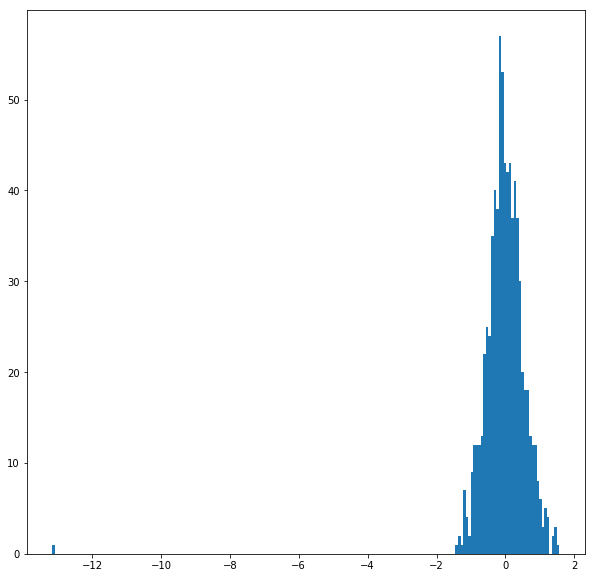

In [22]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [24]:
# Convert the hidden state embeddings into single token vectors

# Holds the list of 12 layer embeddings for each token
# Will have the shape: [# tokens, # layers, # features]
token_embeddings = [] 

# For each token in the sentence...
for token_i in range(len(tokenized_text)):
  
  # Holds 12 layers of hidden states for each token 
    hidden_layers = [] 
  
  # For each of the 12 layers...
    for layer_i in range(len(encoded_layers)):
    
    # Lookup the vector for `token_i` in `layer_i`
        vec = encoded_layers[layer_i][batch_i][token_i]

        hidden_layers.append(vec)
    
    token_embeddings.append(hidden_layers)

# Sanity check the dimensions:
print ("Number of tokens in sequence:", len(token_embeddings))
print ("Number of layers per token:", len(token_embeddings[0]))

Number of tokens in sequence: 22
Number of layers per token: 13


In [25]:
concatenated_last_4_layers = [torch.cat((layer[-1], layer[-2], layer[-3], layer[-4]), 0) for layer in token_embeddings] # [number_of_tokens, 3072]

summed_last_4_layers = [torch.sum(torch.stack(layer)[-4:], 0) for layer in token_embeddings] # [number_of_tokens, 768]

In [26]:
sentence_embedding = torch.mean(encoded_layers[11], 1)

In [27]:
print ("Our final sentence embedding vector of shape:"), sentence_embedding[0].shape[0]

Our final sentence embedding vector of shape:


(None, 768)

In [28]:
print(text)

After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank.


In [29]:
for i,x in enumerate(tokenized_text):
    print(i,x)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [30]:
print ("First fifteen values of 'bank' as in 'bank robber':")
summed_last_4_layers[10][:15]

First fifteen values of 'bank' as in 'bank robber':


tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633,  1.7501, -2.7480,  0.0250,
         0.1940, -1.4371,  0.1224, -0.5929, -0.7653,  2.2977, -4.7485])

In [31]:
print ("First fifteen values of 'bank' as in 'bank vault':")
summed_last_4_layers[6][:15]

First fifteen values of 'bank' as in 'bank vault':


tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031,  0.6318, -2.9078,  1.6307,
        -1.0581, -2.4467,  0.1520, -1.8649, -0.8663,  1.5591, -4.4090])

In [32]:
print ("First fifteen values of 'bank' as in 'river bank':")
summed_last_4_layers[19][:15]

First fifteen values of 'bank' as in 'river bank':


tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334, -0.0527,  1.2063,  4.3940,
        -0.3398, -1.9989,  2.6127,  0.3061, -1.0399,  1.0284, -3.5758])

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

# Compare "bank" as in "bank robber" to "bank" as in "river bank"
different_bank = cosine_similarity(summed_last_4_layers[10].reshape(1,-1), summed_last_4_layers[19].reshape(1,-1))[0][0]

# Compare "bank" as in "bank robber" to "bank" as in "bank vault" 
same_bank = cosine_similarity(summed_last_4_layers[10].reshape(1,-1), summed_last_4_layers[6].reshape(1,-1))[0][0]

In [34]:
print("Similarity of 'bank' as in 'bank robber' to 'bank' as in 'bank vault':",  same_bank)

Similarity of 'bank' as in 'bank robber' to 'bank' as in 'bank vault': 0.9386392


In [35]:
print ("Similarity of 'bank' as in 'bank robber' to 'bank' as in 'river bank':",  different_bank)

Similarity of 'bank' as in 'bank robber' to 'bank' as in 'river bank': 0.6932363
